In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('hybrid_vehicle_price_data.csv')

# Check null values in data

In [3]:
dataset.isnull().sum()

carid          0
vehicle        0
year           0
msrp           0
accelrate      0
mpg            0
mpgmpge        0
carclass       0
carclass_id    0
dtype: int64

# Getting to know data 

In [4]:
dataset.head()


,carid,vehicle,year,msrp,accelrate,mpg,mpgmpge,carclass,carclass_id
0,1,Prius (1st Gen),1997,24509.74,7.46,41.26,41.26,C,1
1,2,Tino,2000,35354.97,8.20,54.10,54.10,C,1
2,3,Prius (2nd Gen),2000,26832.25,7.97,45.23,45.23,C,1
3,4,Insight,2000,18936.41,9.52,53.00,53.00,TS,7
4,5,Civic (1st Gen),2001,25833.38,7.04,47.04,47.04,C,1


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 9 columns):
carid          153 non-null int64
vehicle        153 non-null object
year           153 non-null int64
msrp           153 non-null float64
accelrate      153 non-null float64
mpg            153 non-null float64
mpgmpge        153 non-null float64
carclass       153 non-null object
carclass_id    153 non-null int64
dtypes: float64(4), int64(3), object(2)
memory usage: 10.9+ KB


# preprocessing

Now let's consider the features that we will do exploratary analysis on, we might want to exclude some features before:

We will not consider CarID, because CarID is simply a unique identifier of each car and will be no influence on MSRP.
We do want to consider the name of the vehicle, which reflects model and brands of the vehicle.
We will consider carclass, but since it can be represented by carclass_id, so we can simply include one of them. 
mpg and mpgmpge are corelated variables so we need to consider them first.
year, accelrate we definitely will include into our analysis


check correlation

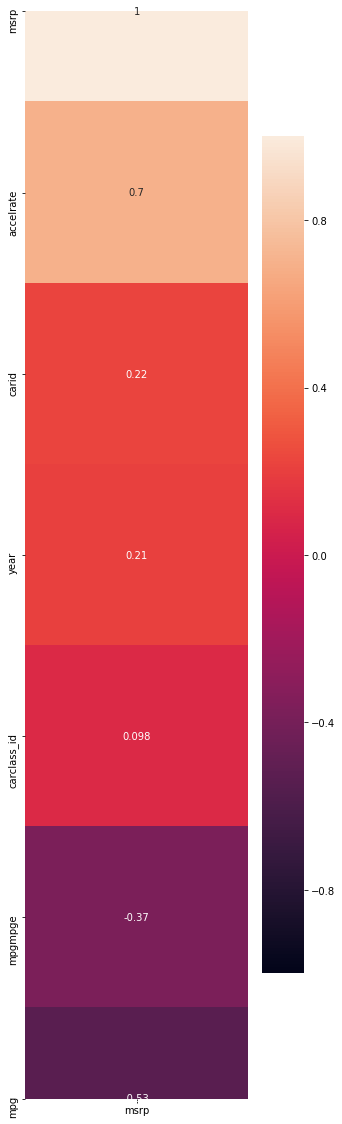

In [6]:
plt.figure(figsize=(5,20))
sns.heatmap(dataset.corr()[['msrp']].sort_values(by=['msrp'],ascending=False).head(50), vmin=-1, annot=True);

There are too many types of vehicles
need to perform data preprocessing 

In [7]:
np.corrcoef(dataset['mpg'], dataset['mpgmpge'])

array([[1.        , 0.66775307],
       [0.66775307, 1.        ]])

drop one of multicolinearlity 

In [8]:
dataset.groupby('vehicle')['msrp'].nunique()

vehicle
3008              1
A5 BSG            1
Accord            1
ActiveHybrid 3    1
ActiveHybrid 5    3
                 ..
Tribute           1
Tribute 2WD       1
Tribute 4WD       1
Vue               2
Yukon 1500        3
Name: msrp, Length: 109, dtype: int64

Based on vehicle info:
The cars with same model may have different vehicle names,
so we split the vehicle name into two parts: first part contains model name, 
second part contains additional information on the vehicle:
It could be different generations or different size 

In [9]:
# new data frame with split value columns
dataset["vehicle1"] = dataset["vehicle"].str.split(" ", n = 1, expand = True)[0]
dataset["vehicle2"] = dataset["vehicle"].str.split(" ", n = 1, expand = True)[1]

  
# Dropping old Name columns
dataset.drop(["vehicle"], axis=1,inplace = True)
# Fill NAs produced by vehicle2
dataset["vehicle2"].fillna("Not applicable", inplace = True) 

In [10]:
dataset.head(5)

,carid,year,msrp,accelrate,mpg,mpgmpge,carclass,carclass_id,vehicle1,vehicle2
0,1,1997,24509.74,7.46,41.26,41.26,C,1,Prius,(1st Gen)
1,2,2000,35354.97,8.20,54.10,54.10,C,1,Tino,Not applicable
2,3,2000,26832.25,7.97,45.23,45.23,C,1,Prius,(2nd Gen)
3,4,2000,18936.41,9.52,53.00,53.00,TS,7,Insight,Not applicable
4,5,2001,25833.38,7.04,47.04,47.04,C,1,Civic,(1st Gen)


Drop columns that not used in analysis

In [11]:
dataset_transformed = dataset.copy()
dataset_transformed.drop(["carid"], axis=1,inplace = True)
dataset_transformed.drop(["carclass"], axis=1,inplace = True)
dataset_transformed.head()

,year,msrp,accelrate,mpg,mpgmpge,carclass_id,vehicle1,vehicle2
0,1997,24509.74,7.46,41.26,41.26,1,Prius,(1st Gen)
1,2000,35354.97,8.20,54.10,54.10,1,Tino,Not applicable
2,2000,26832.25,7.97,45.23,45.23,1,Prius,(2nd Gen)
3,2000,18936.41,9.52,53.00,53.00,7,Insight,Not applicable
4,2001,25833.38,7.04,47.04,47.04,1,Civic,(1st Gen)


encode categorical values

In [12]:


from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
dataset_transformed['vehicle1'] = lb_make.fit_transform(dataset['vehicle1'])
dataset_transformed['vehicle2'] = lb_make.fit_transform(dataset['vehicle2'])

dataset_transformed.head() #Results in appending a new column to df

,year,msrp,accelrate,mpg,mpgmpge,carclass_id,vehicle1,vehicle2
0,1997,24509.74,7.46,41.26,41.26,1,56,0
1,2000,35354.97,8.20,54.10,54.10,1,66,41
2,2000,26832.25,7.97,45.23,45.23,1,56,1
3,2000,18936.41,9.52,53.00,53.00,7,41,41
4,2001,25833.38,7.04,47.04,47.04,1,22,0


In [16]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
dataset_VIF=dataset_transformed.drop(['msrp'], axis=1)
dataset_VIF.head()
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = dataset_VIF.columns



In [18]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(dataset_VIF.values, i)
                          for i in range(len(dataset_VIF.columns))]

In [19]:
print(vif_data)

       feature        VIF
0         year  74.689051
1    accelrate  25.119298
2          mpg  24.070567
3      mpgmpge  10.738890
4  carclass_id   5.572888
5     vehicle1   4.863485
6     vehicle2   5.624157


it is no good to use liner regression model because there are high multicollinearity 
mpg VIF higher than mpgmpge, drop mpg

In [20]:
dataset_transformed.drop(["mpg"], axis=1,inplace = True)
dataset_transformed.head()

,year,msrp,accelrate,mpgmpge,carclass_id,vehicle1,vehicle2
0,1997,24509.74,7.46,41.26,1,56,0
1,2000,35354.97,8.20,54.10,1,66,41
2,2000,26832.25,7.97,45.23,1,56,1
3,2000,18936.41,9.52,53.00,7,41,41
4,2001,25833.38,7.04,47.04,1,22,0


In [21]:
print("After splitting up vehicle name into model and other info, the number of vehicle model catogorries is: ",dataset_transformed.vehicle1.unique().max())
print("The number of vehicle other information catogorries is: ",dataset_transformed.vehicle2.unique().max())


After splitting up vehicle name into model and other info, the number of vehicle model catogorries is:  70
The number of vehicle other information catogorries is:  58


descride the output - msrp

In [22]:
dataset_transformed['msrp'].describe()

count       153.000000
mean      39319.434706
std       21421.126089
min       11849.430000
25%       24995.000000
50%       31950.000000
75%       49650.000000
max      118543.600000
Name: msrp, dtype: float64

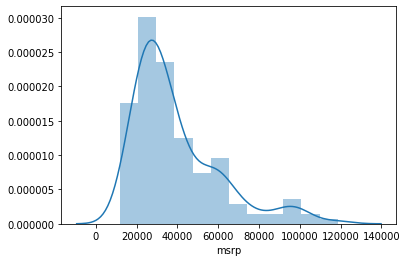

In [23]:
sns.distplot(dataset_transformed['msrp'])

In [24]:
from sklearn import preprocessing

dataset_transformed_normalized= preprocessing.normalize(dataset_transformed)
dataset_transformed_normalized=pd.DataFrame(dataset_transformed_normalized, columns=["year","msrp","accelrate","mpgmpge","carclass_id","vehicle1","vehicle2"])
dataset_transformed_normalized.head()

,year,msrp,accelrate,mpgmpge,carclass_id,vehicle1,vehicle2
0,0.081208,0.996693,0.000303,0.001678,0.000041,0.002277,0.000000
1,0.056479,0.998400,0.000232,0.001528,0.000028,0.001864,0.001158
2,0.074331,0.997230,0.000296,0.001681,0.000037,0.002081,0.000037
3,0.105032,0.994460,0.000500,0.002783,0.000368,0.002153,0.002153
4,0.077226,0.997012,0.000272,0.001815,0.000039,0.000849,0.000000


Split data into training and testing sets

# Split dataset

In [60]:
from sklearn.model_selection import train_test_split
X = dataset_transformed_normalized.drop(['msrp'],axis=1)
y = dataset_transformed_normalized['msrp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# linear regression

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [63]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
accuracy = lr.score(X_test, y_test)

print(accuracy)

0.924901933067463


In [64]:
lr.mse=mean_squared_error(y_test, y_pred)
print(lr.mse)

4.836360741981957e-07


# Random forest

In [65]:
from sklearn.ensemble import RandomForestRegressor
# Fitting Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_estimators=500, max_depth=8, criterion='mse')
rf.fit(X_train, y_train)
rf.score(X_test,y_test)

0.8772557520360326

<BarContainer object of 6 artists>

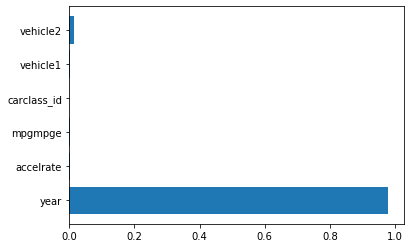

In [66]:
# Display feature importances
rf.feature_importances_
plt.barh(X_train.columns, rf.feature_importances_)


In [67]:
# predictions of test
test_pred = rf.predict(X_test)
test_pred

array([0.99458422, 0.99572223, 0.99954405, 0.99442855, 0.99694246,
       0.99856768, 0.99871048, 0.9995511 , 0.99673996, 0.99849177,
       0.99691294, 0.99136599, 0.99857767, 0.9970486 , 0.99784228,
       0.99954102, 0.99870872, 0.99870993, 0.9977232 , 0.9987669 ,
       0.99693652, 0.99954405, 0.9995511 , 0.99943946, 0.99609915,
       0.99870872, 0.99693816, 0.99938373, 0.99451399, 0.99953693,
       0.9995511 , 0.99782687, 0.99704711, 0.9995511 , 0.99782491,
       0.99781787, 0.99783536, 0.9995511 , 0.99241726])

In [68]:
rf.mse=mean_squared_error(y_test, test_pred)
print(rf.mse)

7.904803497676081e-07


# XGBoost

In [34]:
!pip install xgboost

In [35]:
import xgboost as xgb
trainMatrix = xgb.DMatrix(X_train, y_train)
testMatrix = xgb.DMatrix(X_test, y_test)

In [36]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

In [37]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xgb_param_grid = {"learning_rate":[0.03,0.02,0.01],
                   "max_depth":[2,3,4,5,6,7,8]
                  }
                  
grid_search = GridSearchCV(model_xgb, param_grid=xgb_param_grid, cv=kfolds, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

model_xgb = grid_search.best_estimator_
print(grid_search.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   42.0s finished


[23:32:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'learning_rate': 0.03, 'max_depth': 2}


<BarContainer object of 6 artists>

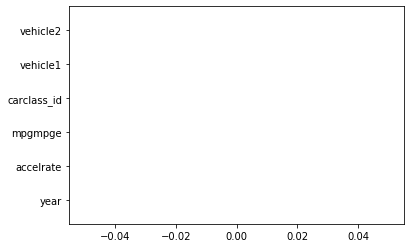

In [38]:
plt.barh(X_train.columns, model_xgb.feature_importances_)

In [39]:
y_pred =model_xgb.predict(X_test)

model_xgb.mse=mean_squared_error(y_test, y_pred)
print(model_xgb.mse)

4.1795547010735795e-05


# LGBM

In [40]:
!pip install lightgbm

In [41]:
import lightgbm as lgbm
lgb_reg = lgbm.LGBMRegressor(objective='regression', learning_rate=0.01, n_estimators=1000, n_jobs=-1)
lgb_param_grid = {"learning_rate":[0.1, 0.01, 0.001],
                   "max_depth":[2, 3, 4, 5]
                  }
                  
grid_search = GridSearchCV(lgb_reg, param_grid=lgb_param_grid, cv=kfolds, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

lgb_reg = grid_search.best_estimator_
print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.6s finished


{'learning_rate': 0.01, 'max_depth': 3}


<BarContainer object of 6 artists>

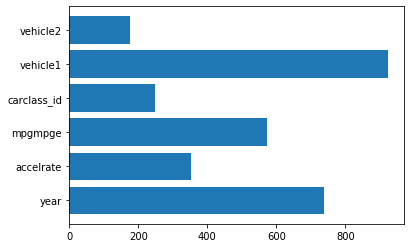

In [42]:
# Display feature importances
plt.barh(X_train.columns, lgb_reg.feature_importances_)

In [43]:
y_pred = lgb_reg.predict(X_test)

lgbm.mse=mean_squared_error(y_test, y_pred)
print(lgbm.mse)

4.101535383781536e-07


# GBM

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
gbdt_param_grid = {"learning_rate":[0.1, 0.01, 0.001],
                   "max_depth":[2, 3, 4, 5]
                  }

                  
grid_search = GridSearchCV(gb_reg, param_grid=gbdt_param_grid, cv=kfolds, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

gb_reg = grid_search.best_estimator_
print(grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s


{'learning_rate': 0.01, 'max_depth': 2}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.9s finished


<BarContainer object of 6 artists>

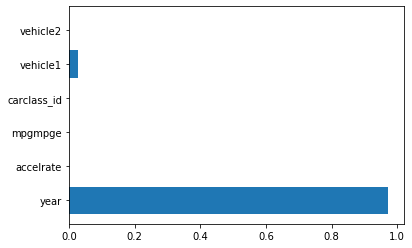

In [55]:
# Display feature importances
plt.barh(X_train.columns, gb_reg.feature_importances_)

In [56]:
y_pred = gb_reg.predict(X_test)

gb_reg.mse=mean_squared_error(y_test, y_pred)
print(gb_reg.mse)

4.077767498175277e-08


In [69]:
data=[[gb_reg.mse,lgbm.mse,model_xgb.mse,rf.mse,lr.mse]]

In [70]:
compare_frame=pd.DataFrame(data,columns=['gradient boosting','lgbm','xgb','random forest','linear regression'])

In [71]:
compare_frame

,gradient boosting,lgbm,xgb,random forest,linear regression
0,4.077767e-08,4.101535e-07,0.000042,7.904803e-07,4.836361e-07


# -The metrics I used here to determine the accuracy of the model on the validation set was mean squared error (MSE), which measures the average squared difference between the values predicted by our model and the actual values. Comparing different models, the Gradient Boosting Machine has smallest MSE that mean GBM is most fitting model for the existing data set in my chose models. However, most importantly, is there a produced reasonable results when I use this model to test other extend dataset.


# -I export feature importances from each model The ‘feature importances’ were extracted from the trained model, and were used to identify the most important features in predicting user conversion. These results indicated year, vehicle 1(first part contains model name), and mpgmpge were overwhelmingly the most significant predictors of price.